In [ ]:
#1 - Após recebermos uma base enriquecida precisamos dividir entre Treino e Teste, para evitar Data Leakage.
#Data Leakage é uma falha que acontece durante os testes de um modelo de machine learning,
#no qual informações são compartilhadas entre um conjunto de dados usado no treinamento
#e outro conjunto de dados que é usado para validar essa modelagem, também chamado de dataset de testes.
#

In [2]:
#importando bibliotecas para uso
import pandas as pd
from funcoes import perfil_base,plot_safra_bad_rate
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

(CVXPY) Feb 09 06:57:55 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.11.4210). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Feb 09 06:57:55 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.11.4210). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')


In [3]:
#Lendo a base de dados fornecida
base_modelo = pd.read_csv("base_modelo.csv",sep=",")

In [4]:
#A função perfil_base auxilia na verificação de métricas básicas da base de dados
resultado = perfil_base(base_modelo, id_col='id', target_col='y', safra_col='safra')

Calcula métricas básicas do perfil da base de dados.
Shape da base: Essa base possui 10738 linhas e 81 colunas
Tipos de variáveis: {dtype('float64'): 75, dtype('int64'): 6}
IDs únicos: 10738
Taxa de maus (bad rate): Bons: 7610(70.9 %), Maus: 3128 (29.1%)
Volumetria das safras: {201401: 854, 201402: 898, 201403: 873, 201404: 955, 201405: 972, 201406: 902, 201407: 968, 201408: 912, 201409: 877, 201410: 933, 201411: 808, 201412: 786}




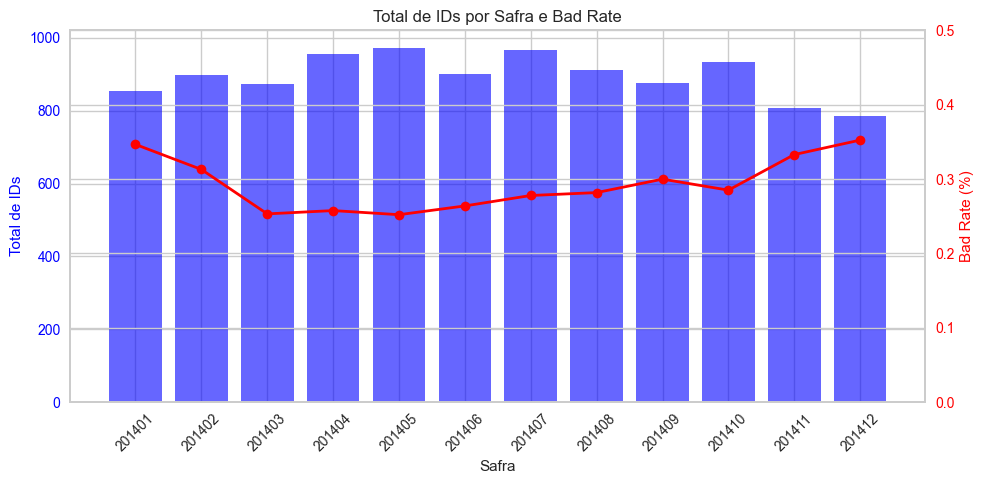

In [5]:
safra_br = plot_safra_bad_rate(base_modelo, safra_col="safra", inadimplente_col="y", bad_rate_min=0, bad_rate_max=0.5)

In [6]:
#Tabela que gerou o gráfico de contratos por safra
safra_br

,safra,contagem,total_maus,total_bons,badrate
0,201401,854,296,558,0.346604
1,201402,898,281,617,0.312918
2,201403,873,221,652,0.253150
3,201404,955,246,709,0.257592
4,201405,972,245,727,0.252058
5,201406,902,238,664,0.263858
6,201407,968,269,699,0.277893
7,201408,912,257,655,0.281798
8,201409,877,263,614,0.299886
9,201410,933,266,667,0.285102


In [7]:
#verificando a tipagem das variáveis
base_modelo.dtypes.to_frame().value_counts(0)

0
float64    75
int64       6
Name: count, dtype: int64

In [8]:
#Verificando se existem duplicatas de IDs
base_modelo['id'].nunique()

10738

In [9]:
#Verificando a Taxa de maus (bad rate) da base
base_modelo['y'].value_counts()/base_modelo['id'].nunique()

y
0    0.708698
1    0.291302
Name: count, dtype: float64

In [10]:
#verificando a quantidade de safras e suas volumetrias
base_modelo['safra'].value_counts().to_frame()

,count
safra,
201405,972
201407,968
201404,955
201410,933
201408,912
201406,902
201402,898
201409,877
201403,873


In [11]:
#Base de Treino
#Vamos utilizar os 10 primeiros meses da safra para o treinamento do modelo
treino = base_modelo[base_modelo['safra']<201410]
treino.shape

(8211, 81)

In [12]:
#A base de treino deve ser dividida em Desenvolvimento e validação (train test)
#Para que possamos avaliar os modelos dentro do mesmo contexto temporal do treinamento OOS
# A base -> treino precisa ser dividida em train, test oos (testar a performance nas safras conhecidas)
# 20% da base é o teste oos.
train, test_oos = train_test_split(treino, test_size=0.2, stratify=treino['y'], random_state=42)
train.shape, test_oos.shape

((6568, 81), (1643, 81))

In [13]:
#Base de Teste OOT
#Vamos separar 3 meses (os mais recentes) para a base de Testes OOT
#Essa base é a que vai de fato simular o modelo "produtivo", e seu potencial preditivo.
teste_oot = base_modelo[base_modelo['safra'].astype(int)>=201410]
teste_oot.shape

(2527, 81)

In [14]:
#Base de desenvolvimento do Modelo
train.to_csv("train.csv",sep=",",index=False,header=True)

In [15]:
#Teste OOS
test_oos.to_csv("test_oos.csv",sep=",",index=False,header=True)

In [16]:
#Teste OOT
teste_oot.to_csv("teste_oot.csv",sep=",",index=False,header=True)

In [17]:
#Volumetria de Ids por Safra por base:
# Train (desenvolvimento) | teste oos (validação) | teste oot (out of time)
train['safra'].value_counts().to_frame().sort_values('safra'),test_oos['safra'].value_counts().to_frame().sort_values('safra'),teste_oot['safra'].value_counts().to_frame().sort_values('safra')

(        count
 safra        
 201401    702
 201402    709
 201403    701
 201404    754
 201405    772
 201406    715
 201407    777
 201408    727
 201409    711,
         count
 safra        
 201401    152
 201402    189
 201403    172
 201404    201
 201405    200
 201406    187
 201407    191
 201408    185
 201409    166,
         count
 safra        
 201410    933
 201411    808
 201412    786)